In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install onnx
!pip install onnx-tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 11.2 MB/s eta 0:00:00


In [ ]:
import onnx
from onnx import helper

onnx_model = onnx.load("/content/drive/MyDrive/EML/simplehrnet_nov23.onnx")

# Define a mapping from old names to new names
name_map = {"input.1": "input_1"}

# Initialize a list to hold the new inputs
new_inputs = []

# Iterate over the inputs and change their names if needed
for inp in onnx_model.graph.input:
    if inp.name in name_map:
        # Create a new ValueInfoProto with the new name
        new_inp = helper.make_tensor_value_info(name_map[inp.name],
                                                inp.type.tensor_type.elem_type,
                                                [dim.dim_value for dim in inp.type.tensor_type.shape.dim])
        new_inputs.append(new_inp)
    else:
        new_inputs.append(inp)

# Clear the old inputs and add the new ones
onnx_model.graph.ClearField("input")
onnx_model.graph.input.extend(new_inputs)

# Go through all nodes in the model and replace the old input name with the new one
for node in onnx_model.graph.node:
    for i, input_name in enumerate(node.input):
        if input_name in name_map:
            node.input[i] = name_map[input_name]

# Save the renamed ONNX model
onnx.save(onnx_model, '/content/drive/MyDrive/EML/simplehrnet_nov23_corrected.onnx')

In [ ]:
import onnx

from onnx_tf.backend import prepare

onnx_model = onnx.load("/content/drive/MyDrive/EML/simplehrnet_nov23_corrected.onnx")  # load onnx model
tf_rep = prepare(onnx_model)  # prepare tf representation
tf_rep.export_graph("/content/Tensorflow")  # export the model

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.NEAREST_NEIGHBOR...)` instead.


In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/Tensorflow") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open("/content/drive/MyDrive/EML/simplehrnet_nov23_corrected.tflite", 'wb') as f:
  f.write(tflite_model)

In [ ]:
import tensorflow as tf

# Path to the TFLite model file
tflite_model_path = '/content/drive/MyDrive/EML/simplehrnet_nov23_corrected.tflite'

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get information about the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print information about the input tensor
print("Input Tensor:")
print("Name:", input_details[0]['name'])
print("Type:", input_details[0]['dtype'])
print("Shape:", input_details[0]['shape'])

# Print information about the output tensor
print("\nOutput Tensor:")
print("Name:", output_details[0]['name'])
print("Type:", output_details[0]['dtype'])
print("Shape:", output_details[0]['shape'])


Input Tensor:
Name: serving_default_input_1:0
Type: <class 'numpy.float32'>
Shape: [  1   3 384 288]

Output Tensor:
Name: PartitionedCall:0
Type: <class 'numpy.float32'>
Shape: [ 1 17 96 72]


# Testing our tflite model

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
# Load the TFLite model
tflite_model_path = '/content/drive/MyDrive/EML/simplehrnet_nov23_corrected.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Prepare input data
from torchvision.transforms import transforms

transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((384, 288)),  # (height, width)
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
image = cv2.VideoCapture(0)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
preprocessed_img = transform(image_rgb).unsqueeze(dim=0)
preprocessed_img = preprocessed_img.numpy().astype(np.float32)
# input_data = np.random.randn(1, 3, 384, 288).astype(np.float32)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], preprocessed_img)

# Run inference
interpreter.invoke()

# Get output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Perform further processing with the output data as needed
print("Output Data:", output_data)


Output Data: [[[[2.3933613e-05 2.3933613e-05 2.3933613e-05 ... 2.3933613e-05
    2.3933613e-05 2.3933613e-05]
   [2.3933613e-05 2.3933613e-05 2.3933613e-05 ... 2.3933613e-05
    2.3933613e-05 2.3933613e-05]
   [2.3933613e-05 2.3933613e-05 2.3933613e-05 ... 2.3933613e-05
    2.3933613e-05 2.3933613e-05]
   ...
   [2.3933613e-05 2.3933613e-05 2.3933613e-05 ... 2.3933613e-05
    2.3933613e-05 2.3933613e-05]
   [2.3933613e-05 2.3933613e-05 2.3933613e-05 ... 2.3933613e-05
    2.3933613e-05 2.3933613e-05]
   [2.3933613e-05 2.3933613e-05 2.3933613e-05 ... 2.3933613e-05
    2.3933613e-05 2.3933613e-05]]

  [[2.3841445e-05 2.3841445e-05 2.3841445e-05 ... 2.3841445e-05
    2.3841445e-05 2.3841445e-05]
   [2.3841445e-05 2.3841445e-05 2.3841445e-05 ... 2.3841445e-05
    2.3841445e-05 2.3841445e-05]
   [2.3841445e-05 2.3841445e-05 2.3841445e-05 ... 2.3841445e-05
    2.3841445e-05 2.3841445e-05]
   ...
   [2.3841445e-05 2.3841445e-05 2.3841445e-05 ... 2.3841445e-05
    2.3841445e-05 2.3841445e-05]
 

**Post processing of output data**

In [ ]:
print(output_data.shape)

(1, 17, 96, 72)


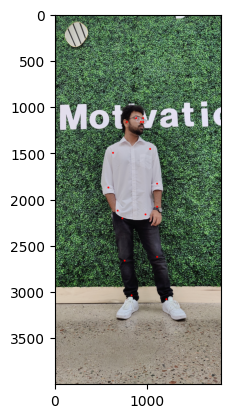

In [ ]:
import matplotlib.pyplot as plt

orig_h, orig_w = image_rgb.shape[:2]
final_heatmaps = output_data[0]
for heatmap in final_heatmaps:
  (y,x) = np.unravel_index(np.argmax(heatmap), heatmap.shape)
  h, w = heatmap.shape
  rescaled_x, rescaled_y = int(x*orig_w/w), int(y*orig_h/h)
  cv2.circle(image_rgb, (rescaled_x, rescaled_y), 20, (255,0,0), -1)

plt.imshow(image_rgb)
plt.show()